# Timsort vs Powersort

## Preliminaries

2023-03-20 Confirmed that the PyPy implementations of Timsort and Powersort
yield the same comparison counts as the CPython implementations.


NB: Careful, when checking this we need to run the sorting call of the list through the
instrumented cpython copies with print debug enabled, by then we have to run `run_information.py`
through the copy of cpython that does *not* print debug info
(as the rank reduction induces extra comparisons),
but we must use the correct sort implementation to get the correct comparison count.

But, long story short, we can use the following two implementations for our purposes,
as they yielded identical results.


In [1]:

if 0:
    %load_ext autoreload
    %autoreload 2
    import Support.Counters as Counters
    import PyPySorters.listsort_powersort
    import PyPySorters.listsort_timsort
    import random


    random.seed(2348905739)
    A = list(range(10000))
    random.shuffle(A)

    C = [Counters.ComparisonCounter(x) for x in A]
    print("Running Powersort")
    Counters.reset_counters()
    PyPySorters.listsort_powersort.sort(C)
    Counters.print_counters()
    C = [Counters.ComparisonCounter(x) for x in A]
    print("Running Timsort")
    Counters.reset_counters()
    PyPySorters.listsort_timsort.sort(C)
    Counters.print_counters()


## Experiments

Now for a more systematic approach.

### Init:

In [63]:
%load_ext autoreload
%autoreload 2
import random
import pandas as pd
import matplotlib.pylab as plt
import math

import PyPySorters.listsort_powersort as powersort
import PyPySorters.listsort_timsort as timsort
import Support.Counters as Counters
import Inputs.Inputs as Inputs

import sortstats.runs as runs
import Inputs.util as util


def cost(lst, sorter):
    wrapped = [Counters.ComparisonCounter(x) for x in lst]
    Counters.reset_counters()
    sorter.sort(wrapped)
    assert Counters.ComparisonCounter.EQ_COMPARISONS == 0
    return {
        # 'algo': sorter.name(),
        'mc': Counters.MergeCosts.MERGECOST,
        'cmps': Counters.ComparisonCounter.COMPARISONS,
        'input-hash': hash(tuple(lst)),
    }


def differences(repetitions, input_generator):
    diffs = pd.DataFrame()
    for i in range(repetitions):
        print(i)
        A = input_generator()
        ps = cost(A, powersort)
        ts = cost(A, timsort)
        diff = {}
        diff['iteration'] = i
        diff['algo'] = 'timsort-over-powersort'
        diff['mc'] = 1.0*ts['mc'] / ps['mc'] if ps['mc'] > 0 else math.nan
        diff['cmps'] = 1.0*ts['cmps'] / ps['cmps'] if ps['cmps'] > 0 else math.nan
        diff['mc-diff'] = 1.0 * ts['mc'] - ps['mc']
        diff['cmps-diff'] = 1.0 * ts['cmps'] - ps['cmps']
        diff['mc-powersort'] = ps['mc']
        diff['cmps-powersort'] = ps['cmps']
        diff['input-hash'] = ps['input-hash']
        diffs = diffs.append(diff, ignore_index=True)
    return diffs


def contest(input_generator,
            reps=100, n=10000, seed=2348905734,
            print_describe=True,
            describe_percentiles=[0.01, .25, .5,],
            show_histograms=False,
            show_scatter=True,
            return_diffs=False,
            ):
    print('Running  ...')
    RNG = random.Random(seed)
    diffs = differences(reps, lambda: input_generator(n, RNG))
    if print_describe:
        print(diffs['mc']  .describe(percentiles=describe_percentiles))
        print()
        print(diffs['cmps'].describe(percentiles=describe_percentiles))
        print()
    if show_histograms:
        plt.hist(diffs['mc'])
        plt.show()
        plt.hist(diffs['cmps'])
        plt.show()
    if show_scatter:
        plt.scatter('mc', 'cmps', data = diffs, marker='x', )
        plt.show()
    return diffs if return_diffs else None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Random Permutations

For random permutations, not too much is saved,
but at least we hard do worse.


Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
count    2.000000e+02
mean     1.001003e+00
std      2.226018e-16
min      1.001003e+00
1%       1.001003e+00
25%      1.001003e+00
50%      1.001003e+00
max      1.001003e+00
Name: mc, dtype: float64

count    200.000000
mean       1.000666
std        0.000207
min        1.000134
1%         1.00

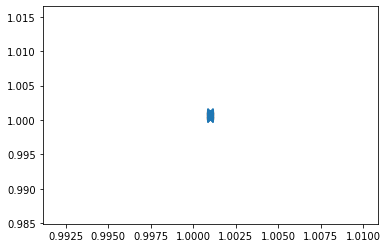

done


In [7]:
contest((lambda n, rand: Inputs.random_permutation(n, rand)))

### Expected $\sqrt n$ Random Runs

Runs are filled from random permutation.

Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.051177
std        0.036090
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       1.030907
std        0.019930
min        0.996263
1%         0.997515
25%        1.017729
50%        1.027206
max        1.088662
Name: cmps, dtype: float64



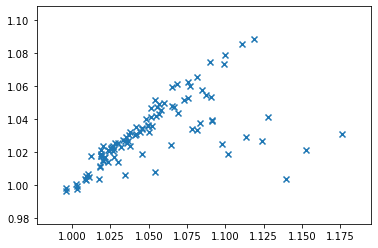

In [17]:
contest(lambda n, rand: Inputs.random_runs(n, int(n ** 0.5), rand))

### Expected $\sqrt n$ Random Runs

Again, but with runs filled with descendingly before sorting.
--> Makes merging very cheap in terms of #cmps.

Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.051177
std        0.036090
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       0.999062
std        0.005195
min        0.985194
1%         0.988803
25%        0.996028
50%        0.998013
max        1.022445
Name: cmps, dtype: float64



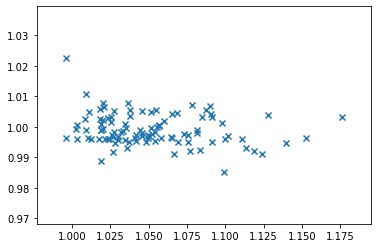

In [7]:
import sortstats.runs as runs
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_high_to_low(lst, run_lens, 1)
    return lst

contest(input_generator)

alternative way to get the very same

Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.051177
std        0.036090
min        0.995674
1%         0.996001
10%        1.012240
50%        1.044964
90%        1.099173
99%        1.153047
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       0.999062
std        0.005195
min        0.985194
1%         0.988803
10%        0.994511
50%        0.998013
90%        1.005401
99%        1.011011
max        1.022445
Name: cmps, dtype: float64



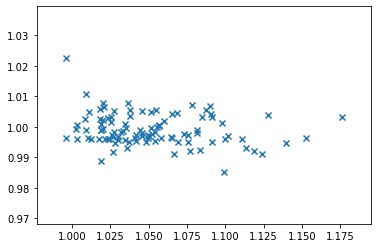

In [67]:
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_dups_desc(lst, run_lens, 1)
    return lst

contest(input_generator, describe_percentiles=[0.01,0.1,0.5,0.9,0.99])


In [66]:
# Procudes one long descending run ...

def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_dups_desc(lst, run_lens, 1)
    lst = util.rank_reduce_ties_desc(lst)
    return lst

contest(input_generator, reps=10, show_scatter=False)


Running  ...
0
1
2
3
4
5
6
7
8
9
count    0.0
mean     NaN
std      NaN
min      NaN
1%       NaN
25%      NaN
50%      NaN
max      NaN
Name: mc, dtype: float64

count    10.0
mean      1.0
std       0.0
min       1.0
1%        1.0
25%       1.0
50%       1.0
max       1.0
Name: cmps, dtype: float64



### Expected $\sqrt n$ Random Runs

Runs are filled by rank-reducing a list where each run is 1,2,3,..., but ends with n

Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.050959
std        0.035949
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       1.039807
std        0.027954
min        0.992677
1%         0.996313
25%        1.022986
50%        1.030008
max        1.151571
Name: cmps, dtype: float64



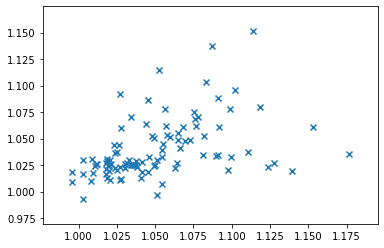

In [11]:
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_same(lst, run_lens, 1)
    lst = util.rank_reduce(lst)
    return lst

contest(input_generator)


Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.050959
std        0.035949
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       1.039807
std        0.027954
min        0.992677
1%         0.996313
25%        1.022986
50%        1.030008
max        1.151571
Name: cmps, dtype: float64



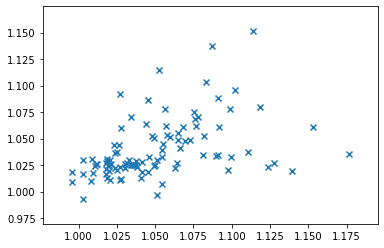

In [10]:
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_same(lst, run_lens, 1)
    return lst

contest(input_generator)


Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.051177
std        0.036090
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       1.041463
std        0.028180
min        0.993832
1%         0.997320
25%        1.024032
50%        1.032463
max        1.155758
Name: cmps, dtype: float64



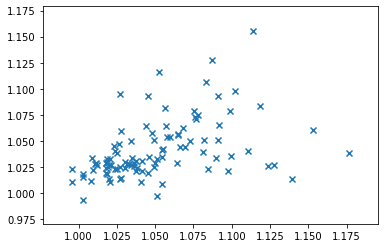

In [12]:
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_same(lst, run_lens, 1)
    lst= util.rank_reduce_ties_desc(lst)
    return lst

contest(input_generator)


Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.051177
std        0.036090
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       1.039048
std        0.028600
min        0.975627
1%         1.001016
25%        1.021745
50%        1.029991
max        1.166825
Name: cmps, dtype: float64



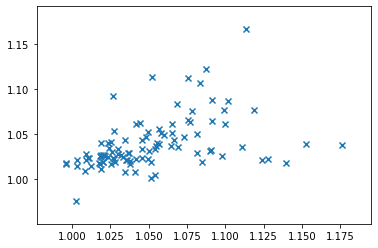

In [20]:
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_same(lst, run_lens, 1, use_n_as_last_entry=False)
    # lst= util.rank_reduce_ties_desc(lst)
    return lst

contest(input_generator)


Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
count    100.000000
mean       1.051177
std        0.036090
min        0.995674
1%         0.996001
25%        1.023922
50%        1.044964
max        1.176370
Name: mc, dtype: float64

count    100.000000
mean       1.040475
std        0.029566
min        0.985820
1%         1.000580
25%        1.021512
50%        1.031185
max        1.167766
Name: cmps, dtype: float64



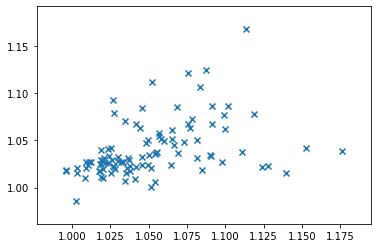

In [21]:
def input_generator(n, RNG):
    sqrtn = int(n ** 0.5)
    lst = Inputs.random_runs(n, sqrtn, RNG)
    run_lens = runs.run_lengths(runs.runs(lst))
    Inputs.fill_with_asc_runs_same(lst, run_lens, 1, use_n_as_last_entry=False)
    lst= util.rank_reduce_ties_desc(lst)
    return lst

contest(input_generator)


### RTim inputs with large blowup


Running  ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

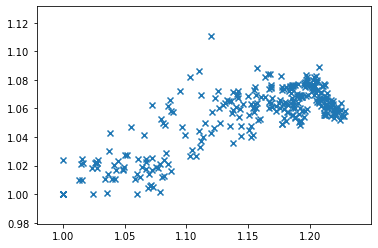

,algo,cmps,cmps-diff,cmps-powersort,input-hash,iteration,mc,mc-diff,mc-powersort
0,timsort-over-powersort,1.000000,0.0,9999.0,8.946642e+17,0.0,NaN,0.0,0.0
1,timsort-over-powersort,1.000000,0.0,9999.0,8.946642e+17,1.0,NaN,0.0,0.0
2,timsort-over-powersort,1.000000,0.0,9998.0,-6.635436e+18,2.0,NaN,0.0,0.0
3,timsort-over-powersort,1.000000,0.0,22498.0,1.391354e+18,3.0,1.000000,0.0,15000.0
4,timsort-over-powersort,1.000000,0.0,24018.0,-3.186156e+18,4.0,1.000000,0.0,16000.0
...,...,...,...,...,...,...,...,...,...
295,timsort-over-powersort,1.023816,1471.0,61766.0,8.658610e+18,295.0,1.028496,2064.0,72432.0
296,timsort-over-powersort,1.022255,1380.0,62008.0,-7.351048e+18,296.0,1.026976,1962.0,72732.0
297,timsort-over-powersort,1.010178,635.0,62387.0,6.021506e+18,297.0,1.015178,1110.0,73134.0
298,timsort-over-powersort,1.010151,635.0,62558.0,-6.205821e+18,298.0,1.013064,960.0,73482.0


In [65]:
n_runs = 1
def input_generator(n, RNG):
    global n_runs
    blowup = n//n_runs
    n = blowup * n_runs
    run_lens = Inputs.timsort_drag_run_lengths(n//blowup)
    # print([r*blowup for r in run_lens])
    lst = [0] * n
    Inputs.fill_with_asc_runs_same(lst, run_lens, blowup, use_n_as_last_entry=False)
    lst= util.rank_reduce_ties_desc(lst)
    n_runs += 1
    return lst

contest(input_generator, reps=300, return_diffs=True)


In [70]:
n_runs = 49
def input_generator(n, RNG):
    global n_runs
    blowup = n//n_runs
    n = blowup * n_runs
    run_lens = Inputs.timsort_drag_run_lengths(n//blowup)
    print([r*blowup for r in run_lens])
    print(len(run_lens))
    lst = [0] * n
    Inputs.fill_with_asc_runs_same(lst, run_lens, blowup, use_n_as_last_entry=False)
    lst= util.rank_reduce_ties_desc(lst)
    return lst

contest(input_generator, reps=1, show_scatter=False)


Running  ...
0
[612, 408, 204, 408, 204, 408, 204, 408, 204, 408, 408, 204, 204, 408, 204, 408, 204, 408, 408, 204, 204, 408, 408, 204, 408, 408, 204, 204, 204, 408, 408]
31
count    1.000000
mean     1.119835
std           NaN
min      1.119835
1%       1.119835
25%      1.119835
50%      1.119835
max      1.119835
Name: mc, dtype: float64

count    1.000000
mean     1.110775
std           NaN
min      1.110775
1%       1.110775
25%      1.110775
50%      1.110775
max      1.110775
Name: cmps, dtype: float64



In [64]:
def input_generator(n, RNG):
    n_runs = n//65 # well above min_run_len
    blowup = n//n_runs
    n = blowup * n_runs
    run_lens = Inputs.timsort_drag_run_lengths(n//blowup)
    # print([r*blowup for r in run_lens])
    lst = [0] * n
    Inputs.fill_with_asc_runs_same(lst, run_lens, blowup, use_n_as_last_entry=False)
    lst= util.rank_reduce_ties_desc(lst)
    n_runs += 1
    return lst

contest(input_generator, n=10**6, reps=1, show_scatter=False)


Running  ...
0
count    1.00000
mean     1.34363
std          NaN
min      1.34363
1%       1.34363
25%      1.34363
50%      1.34363
max      1.34363
Name: mc, dtype: float64

count    1.000000
mean     1.068332
std           NaN
min      1.068332
1%       1.068332
25%      1.068332
50%      1.068332
max      1.068332
Name: cmps, dtype: float64

